# CSSCVI Synthetic Example

A simple synthetic ZINB dataset with 2 attributes each having 2 conditions (on / off).

This notebook will run on CPU if no GPU is detected. View the text output of the imports code cell to see which device will be used in the session.

Note that this is a simple demo and the models trained are by no means claimed to be optimally tuned for hyperparameters.

## Imports

In [1]:
## Imports & Seeds
import torch, pyro, os, re, sys, warnings
import numpy as np
import pandas as pd
from wh.models.scvi_variants import SCVI, SCANVI, CSSCVI
from wh.models.basics import _broadcast_inputs, LinRegressor, _make_func, _make_fc
from wh.scripts.training import train_pyro, train_pyro_disjoint_param, get_device, train_lin_reg
from wh.scripts.metrics import get_reproduction_error, _get_subset, self_profile_reproduction, gen_profile_reproduction, get_normalized_profile, _get_rmse_n_to_1, _get_chamf_n_to_1, _get_sliced_wasserstein_n_to_1, _get_corr_n_to_1, _get_normalized_profile, knn_error, kmeans_nmi, kmeans_ari
from wh.data.real_data import construct_labels, distrib_dataset, MetadataConverter, AnndataConverter, _factors_to_col, make_lin_reg_data

from torchviz import make_dot
import torch.utils.data as utils
from itertools import combinations, product, permutations, chain
import inspect
import torch.optim as opt
from tqdm.notebook import tqdm

import umap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math
import ot
from typing import Iterable, Literal
from scipy.stats import pearsonr
import anndata as ad
import scanpy as sc

import torch.nn as nn
import pyro.distributions as dist

import scib
from tqdm import trange
import pickle
from sklearn.preprocessing import OneHotEncoder


np.random.seed(42)
torch.manual_seed(42)
pyro.util.set_rng_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gamma_apr = np.round((1.-math.gamma(1+1.e-8))*1.e14 )*1.e-6

#device="cpu"

reducer = umap.UMAP(metric="correlation")


print(f"Device: {device}")

Device: cpu


## Dataset

Use this block to tune the parameters of the synthetic dataset.

In [2]:
# Helpers for plots
def _transform_labels(labels):
    return torch.hstack((labels[:,:2].argmax(-1).view(-1,1), labels[:,2:].argmax(-1).view(-1,1)))

def get_labels(labels):
    labs = _transform_labels(labels)
    df = pd.DataFrame(labs)
    df["comb"] = df.apply(lambda x : str(x[0]) + "," + str(x[1]), axis = 1)
    return torch.tensor(pd.get_dummies(df["comb"]).astype(int).to_numpy())


#################### DATASET PARAMS #########################################################################################
n = 500  # Number of points in each attribute combination
lib_size=1000  # Total counts of generated points
batch_size=32 # Loader batch size
z_dim, w_dim, x_dim = 20, 10, 1000  # Latent dims of attributes and half dim of outputs
theta = torch.tensor([10.0]*(x_dim*2))   # Inverse dispersions
z_mean, z_std = 0, 1  # Common latent parameters (gaussian)
a_10_mean, a_10_std, a_11_mean, a_11_std = 2, 1, 10, 1  # Attribute 1 parameters: a10 --> Attribute 1 Off //  a11 --> Attribute 1 On // Parameters for respective gaussians
a_20_mean, a_20_std, a_21_mean, a_21_std = -1, 1, 5, 1  # Attribute 2 parameters: a20 --> Attribute 2 Off // a21 --> Attribute 2 On // Parameters for respective gaussians
##################################################################################################################################


# create mappers for random vector of 1000: z, zw1, zw2, zw1w2
z_to_p1 = _make_fc([int(z_dim), 128, 128, int(x_dim/4)]) 
zw1_to_p2 = _make_fc([int(z_dim + w_dim), 128, 128, int(x_dim/4)])
zw2_to_p3 = _make_fc([int(z_dim + w_dim), 128, 128, int(x_dim/4)])
zw1w2_to_p4 = _make_fc([int(z_dim + w_dim*2), 128, 128, int(x_dim/4)])
lat_to_x = _make_func(in_dims=x_dim, hidden_dims=[128]*2, out_dim=x_dim*2, last_config="reparam", dist_config="zinb")


# Generate dataset
## Common
z_s = torch.normal(z_mean, z_std, size=(n*4, z_dim))


## Specific
w_0_0 = torch.concat((torch.normal(a_10_mean, a_10_std, size=(n, w_dim)), torch.normal(a_20_mean, a_20_std, size=(n, w_dim))), dim=-1)
w_0_1 = torch.concat((torch.normal(a_10_mean, a_10_std, size=(n, w_dim)), torch.normal(a_21_mean, a_21_std, size=(n, w_dim))), dim=-1)
w_1_0 = torch.concat((torch.normal(a_11_mean, a_11_std, size=(n, w_dim)), torch.normal(a_20_mean, a_20_std, size=(n, w_dim))), dim=-1)
w_1_1 = torch.concat((torch.normal(a_11_mean, a_11_std, size=(n, w_dim)), torch.normal(a_21_mean, a_21_std, size=(n, w_dim))), dim=-1)

## Combine Ws
w_s = torch.concat((w_0_0, w_0_1, w_1_0, w_1_1))

## Combine into full latents
zw_s = torch.concat((z_s, w_s), dim=-1)



# Generate from latents
with torch.no_grad():
    ## Common
    p1 = z_to_p1(zw_s[:,:20])

    ## Common + w1
    p2 = zw1_to_p2(zw_s[:,:30])

    ## Common + w2
    p3 = zw2_to_p3(torch.concat((zw_s[:,:20], zw_s[:,30:]), dim=-1))

    ## Common + w1 + w2
    p4 = zw1w2_to_p4(zw_s)


# Concat mixed params
p_s = torch.concat((p1,p2,p3,p4), dim=-1)


# ZINB
gate_logits, mu = lat_to_x(p_s)
nb_logits = (lib_size * mu + 1e-3).log() - (theta + 1e-3).log()
x_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits, total_count=theta,
                                                       logits=nb_logits, validate_args=False)

data = x_dist.sample()
labels = torch.concat((torch.tensor([1,0,1,0]).repeat((n,1)), torch.tensor([1,0,0,1]).repeat((n,1)), torch.tensor([0,1,1,0]).repeat((n,1)), torch.tensor([0,1,0,1]).repeat((n,1))))


dataset = utils.TensorDataset(data.double(), labels.double(), labels.double())
train_set, test_set = utils.random_split(dataset, [0.8, 0.2])
train_loader, test_loader = utils.DataLoader(train_set, num_workers=4, batch_size=batch_size, shuffle=True), utils.DataLoader(test_set, num_workers=4, batch_size=batch_size, shuffle=False)

## Dataset Visualization

This block offers a simple visual understanding of the dataset generated in the previous step. We use correlation as the metric for UMAP to accentuate the differences between different attribute classes.

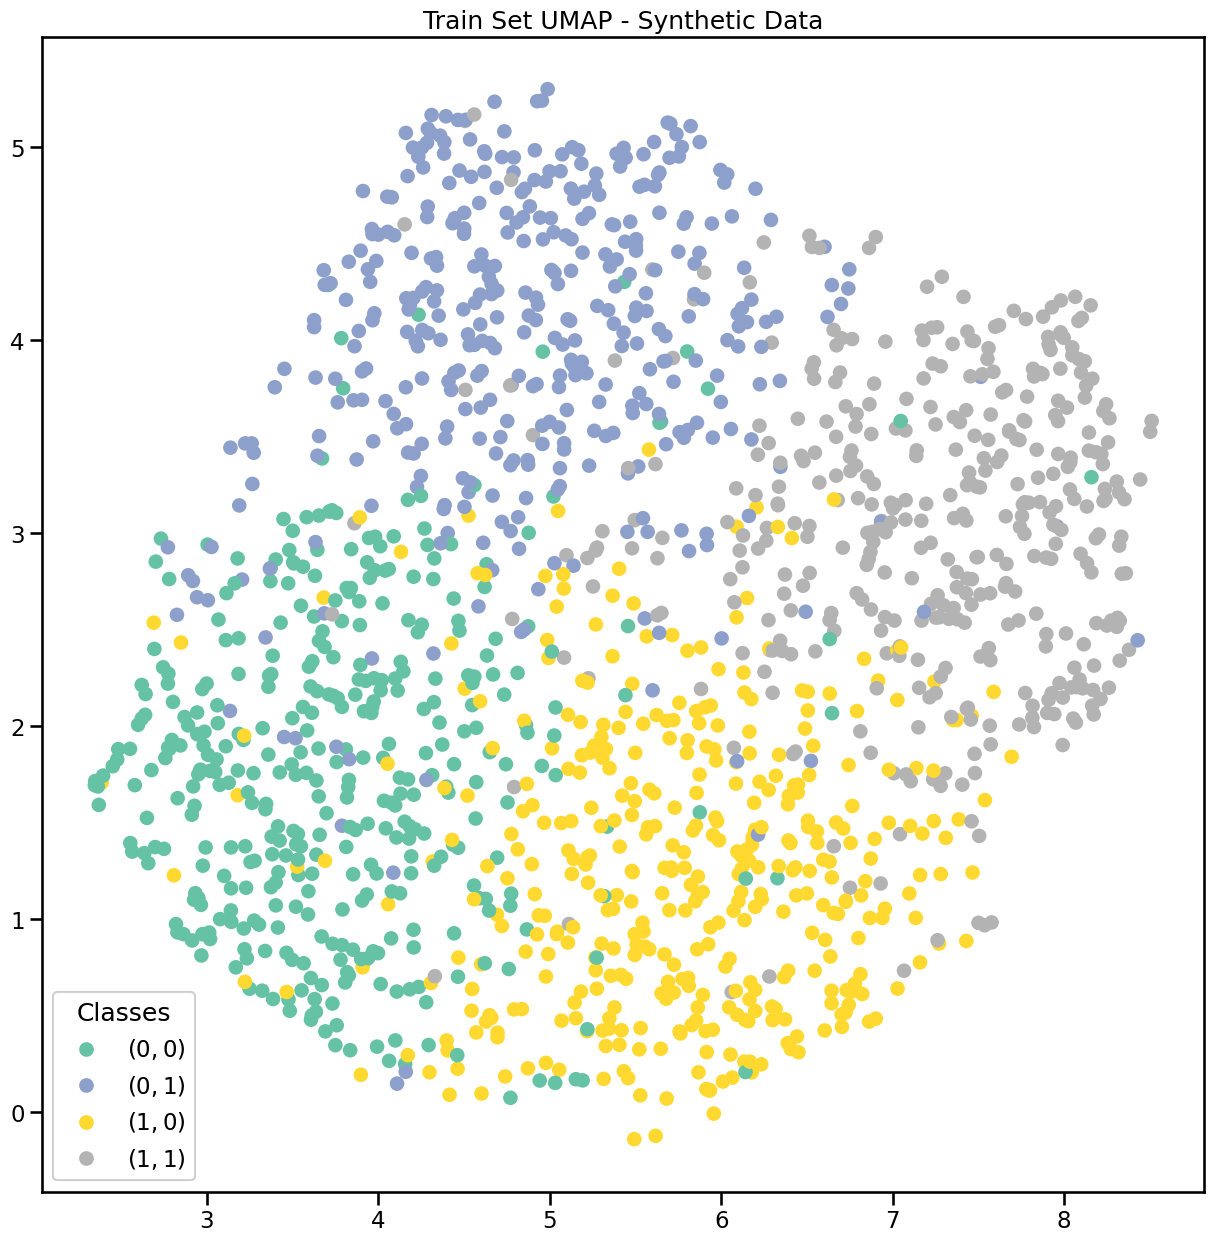

In [3]:
data_umap = reducer.fit_transform(train_set[:][0])

fig, ax = plt.subplots(1,1,figsize=(15,15))

scatter = ax.scatter(data_umap[:, 0], data_umap[:, 1], c=np.array(get_labels(train_set[:][1]).argmax(-1)), cmap="Set2", )


elems = list(scatter.legend_elements())
elems[1] = ['$\\mathdefault{(0,0)}$',
 '$\\mathdefault{(0,1)}$',
 '$\\mathdefault{(1,0)}$',
 '$\\mathdefault{(1,1)}$']

legend = ax.legend(*elems,
                    loc="lower left", title="Classes")

ax.add_artist(legend)
ax.set_title("Train Set UMAP - Synthetic Data")


plt.savefig("train_umap_synthetic.png", dpi=300, bbox_inches="tight")

plt.show()

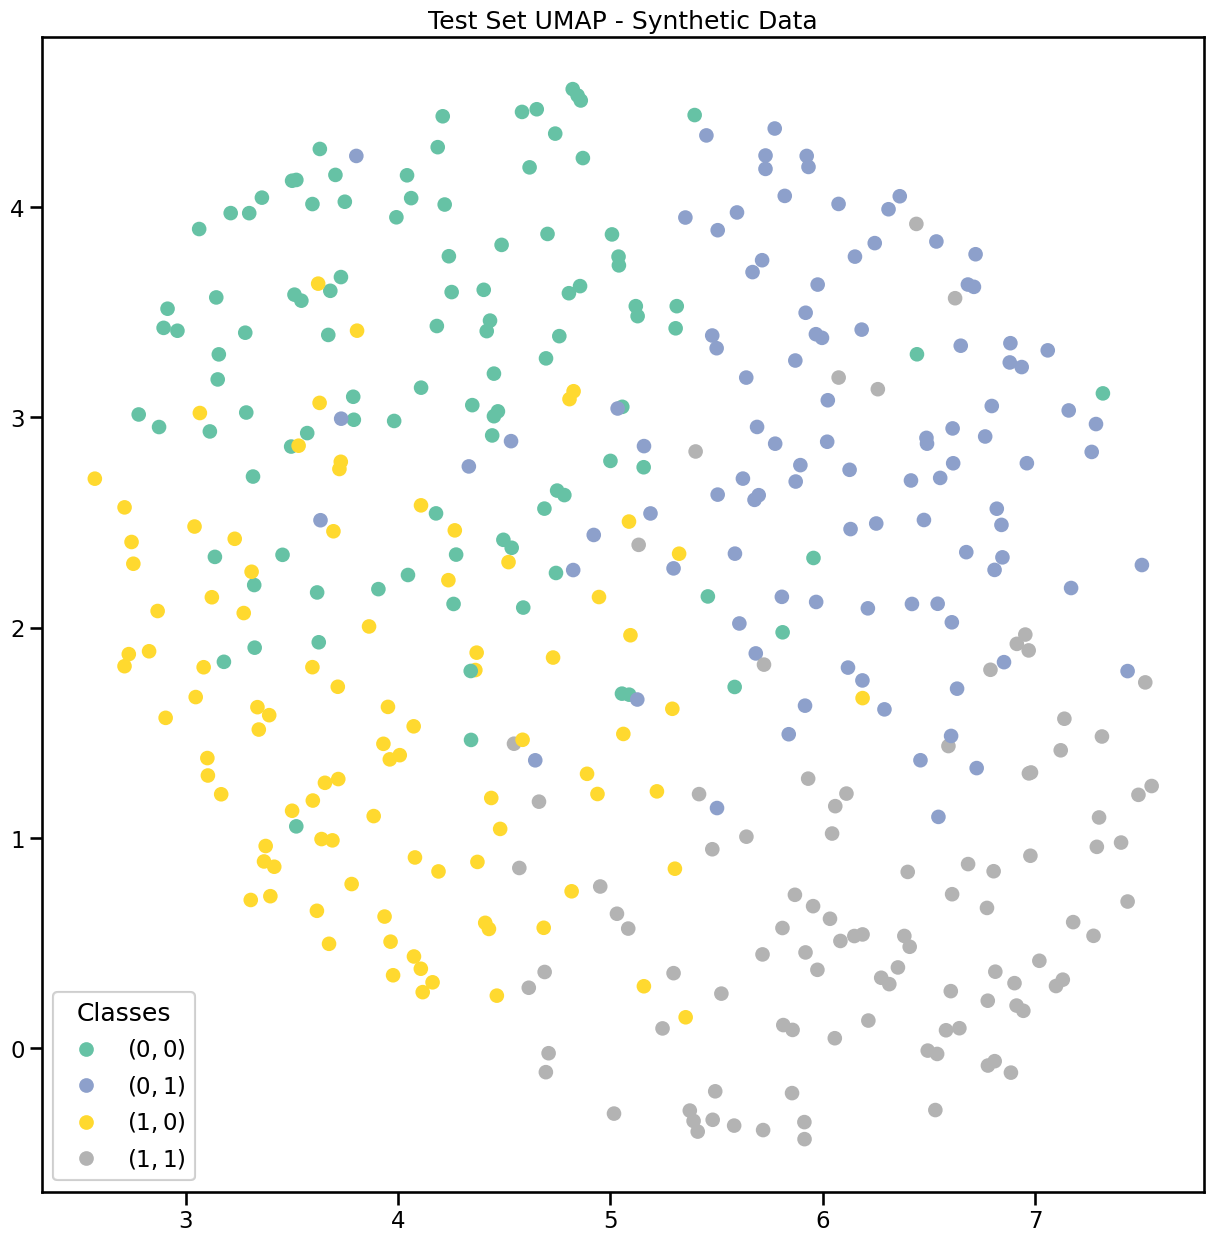

In [4]:
data_umap = reducer.fit_transform(test_set[:][0])

fig, ax = plt.subplots(1,1,figsize=(15,15))


scatter = ax.scatter(data_umap[:, 0], data_umap[:, 1], c=np.array(get_labels(test_set[:][1]).argmax(-1)), cmap="Set2", )


elems = list(scatter.legend_elements())
elems[1] = ['$\\mathdefault{(0,0)}$',
 '$\\mathdefault{(0,1)}$',
 '$\\mathdefault{(1,0)}$',
 '$\\mathdefault{(1,1)}$']

legend = ax.legend(*elems,
                    loc="lower left", title="Classes")

ax.add_artist(legend)

ax.set_title("Test Set UMAP - Synthetic Data")

plt.savefig("test_umap_synthetic.png", dpi=300, bbox_inches="tight")


plt.show()

## Model

This block lets you train the model from scratch or load pre-trained parameters for evaluation.

### Load

In [5]:
l_mean, l_scale = train_set[:][0].sum(-1).log().mean(), train_set[:][0].sum(-1).log().var()
len_attrs = [2,2]

pyro.clear_param_store()

csscvi = CSSCVI(num_genes=train_set[0][0].shape[0], num_labels=sum(len_attrs),
                l_loc=l_mean, l_scale=l_scale,
                alphas=[1, 1], w_loc=[0,3], w_scale=[0.1, 1], hidden_dim=256, num_layers=3, w_dim=10, latent_dim=20, len_attrs = len_attrs,
                scale_factor=1.0 / (batch_size * train_set[0][0].shape[0]), batch_correction=False).double()


csscvi.load("csscvi_synthetic_example")

### Train 

In [ ]:
l_mean, l_scale = train_set[:][0].sum(-1).log().mean(), train_set[:][0].sum(-1).log().var()
len_attrs = [2,2]

pyro.clear_param_store()

csscvi = CSSCVI(num_genes=train_set[0][0].shape[0], num_labels=sum(len_attrs),
                l_loc=l_mean, l_scale=l_scale,
                alphas=[1, 1], w_loc=[0,3], w_scale=[0.1, 1], hidden_dim=256, num_layers=3, w_dim=10, latent_dim=20, len_attrs = len_attrs,
                scale_factor=1.0 / (batch_size * train_set[0][0].shape[0]), batch_correction=False).double()

csscvi, train_loss, test_loss, param_nonc_names, param_c_names = train_pyro_disjoint_param(csscvi, train_loader=train_loader, test_loader=test_loader, verbose=True, num_epochs=650, lr=1e-2, eps=1e-2, style="joint", warmup=0)

csscvi.save("csscvi_synthetic_example")

## Evaluation Metrics

Calculates metrics on aggregates (RMSE - Pearson Correlation) or point clouds (SWD - CD). Note that for the synthetic data, point cloud metrics are more indicative of performance. 

In [6]:
csscvi.eval()
predictive = pyro.infer.Predictive(csscvi.generate, num_samples=1)

for metric in ["rmse", "corr", "swd", "chamfer"]:
    preds_mean_error, pred_profiles, preds = get_reproduction_error(test_set, predictive, metric=metric, n_trials=10, verbose=True, use_cuda=False)
    print(f"{metric} : {np.round(preds_mean_error, 3)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.69it/s]


rmse : 2.384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.72it/s]


corr : -0.074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.39it/s]


swd : 0.337


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3043.54it/s]

chamfer : 0.689


## Qualitative Evaluation

This section shows various approaches to understanding the model and its objectives.

### Reconstructed Dataset Visualization

This block offers a visual understanding of the reconstructed data, which closely resembles the previous visualization above

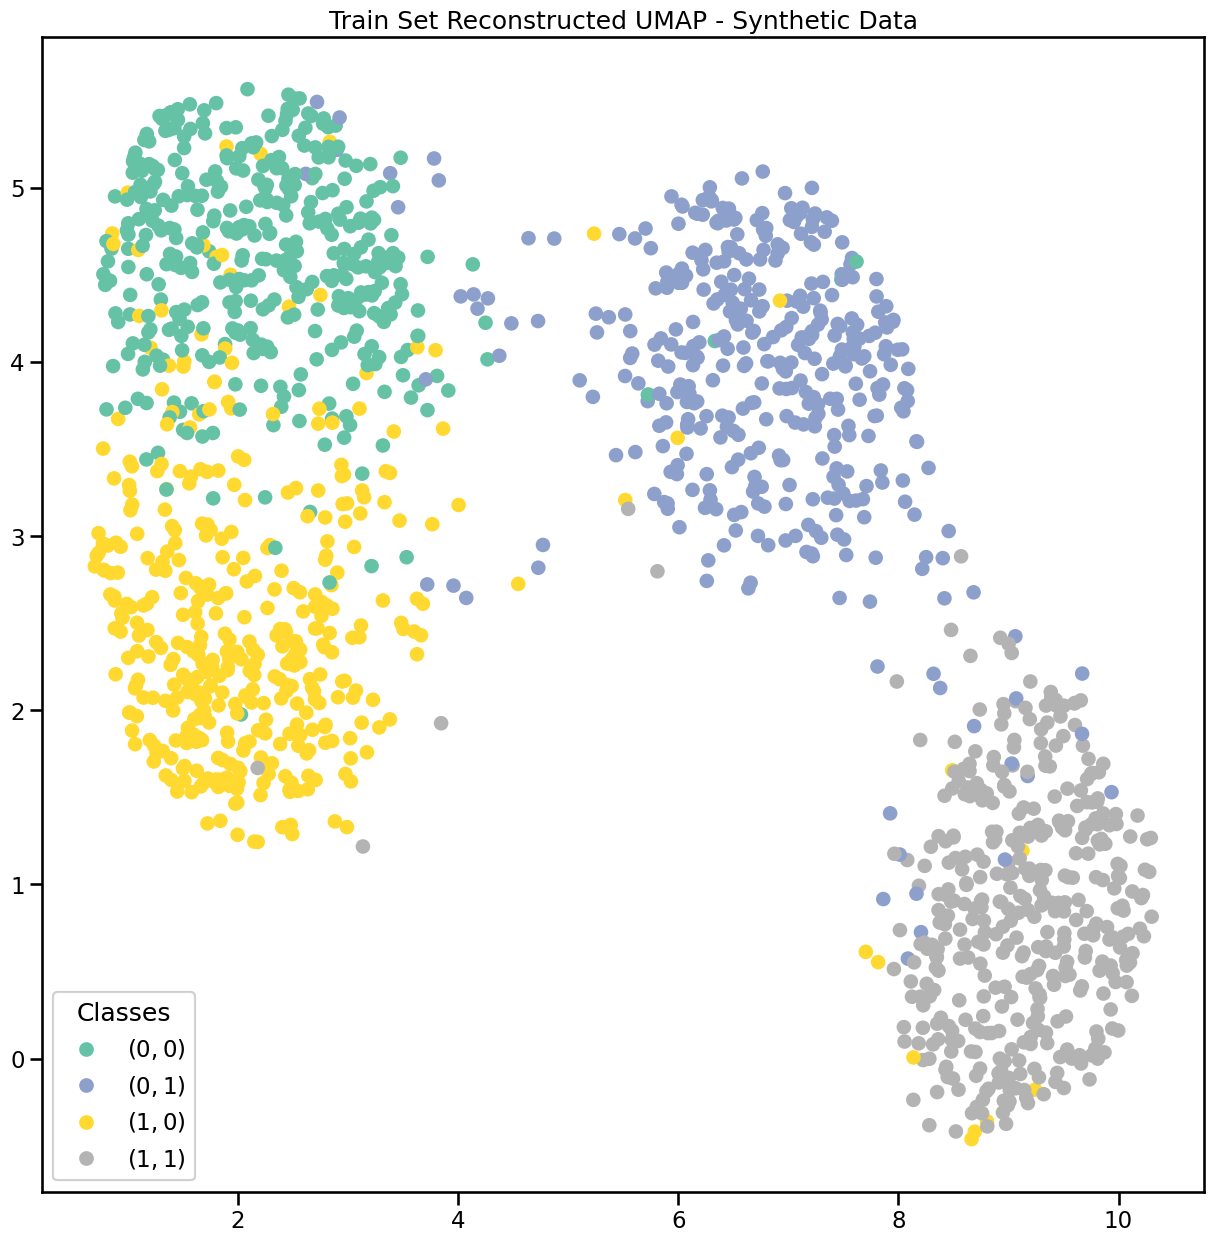

In [7]:
dat_t = predictive(train_set[:][0], train_set[:][1], train_set[:][1])["x"]
data_umap = reducer.fit_transform(dat_t[0])

fig, ax = plt.subplots(1,1,figsize=(15,15))

scatter = ax.scatter(data_umap[:, 0], data_umap[:, 1], c=np.array(get_labels(train_set[:][1]).argmax(-1)), cmap="Set2")


elems = list(scatter.legend_elements())
elems[1] = ['$\\mathdefault{(0,0)}$',
 '$\\mathdefault{(0,1)}$',
 '$\\mathdefault{(1,0)}$',
 '$\\mathdefault{(1,1)}$']

legend = ax.legend(*elems,
                    loc="lower left", title="Classes")

ax.add_artist(legend)

ax.set_title("Train Set Reconstructed UMAP - Synthetic Data")

plt.savefig("train_recon_umap_synthetic.png", dpi=300, bbox_inches="tight")

plt.show()

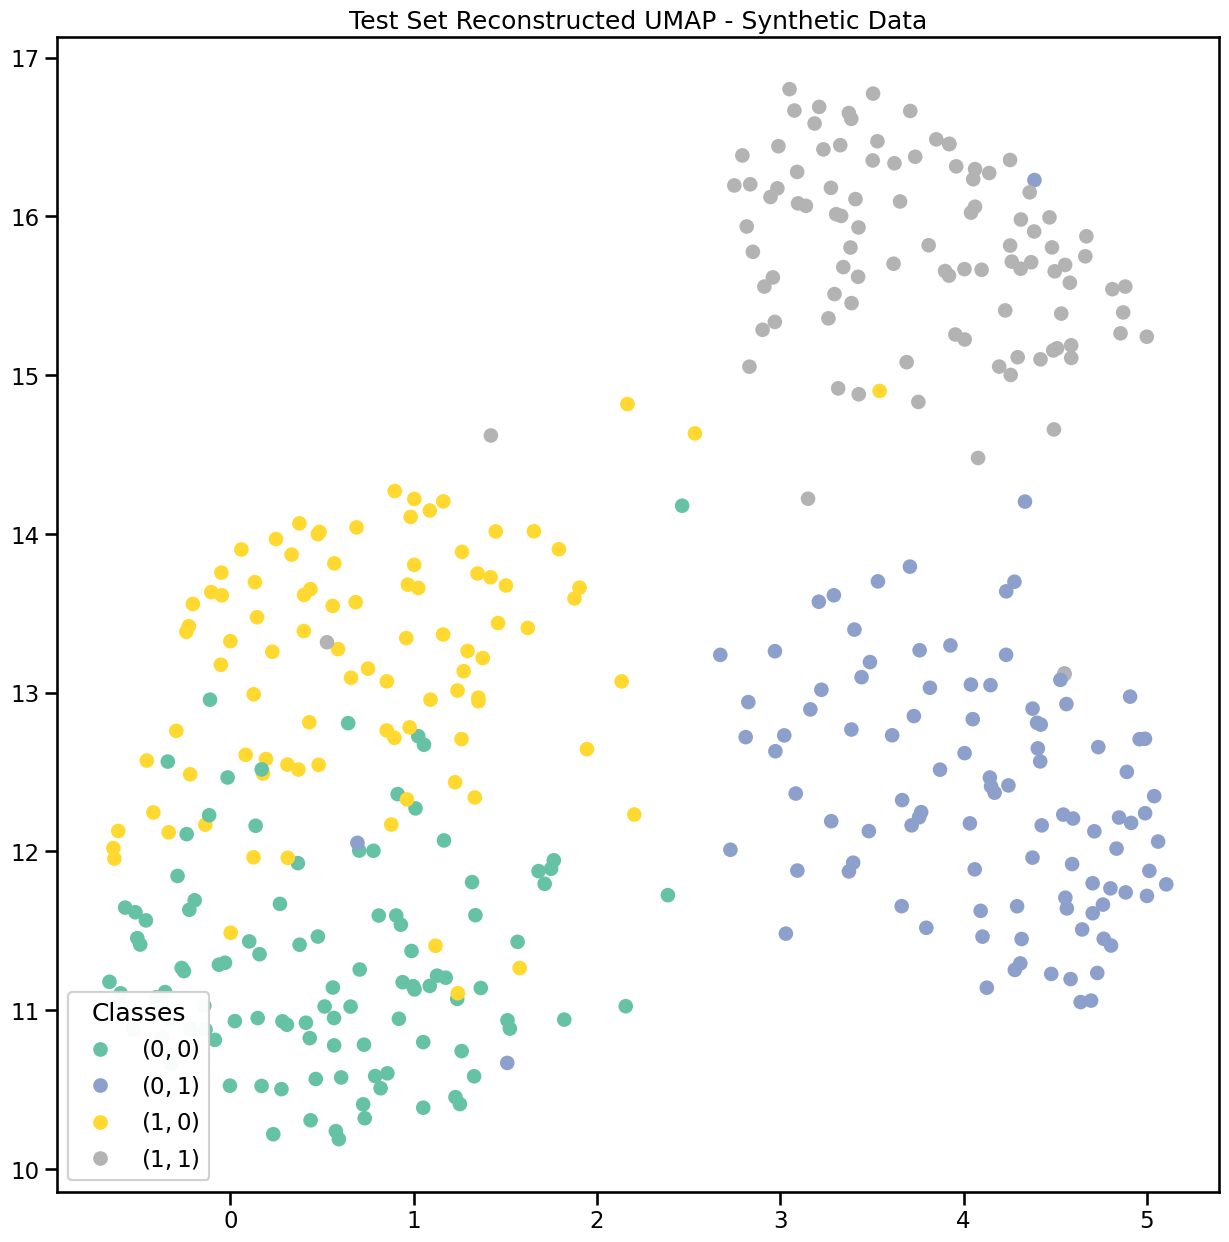

In [8]:
dat_t = predictive(test_set[:][0], test_set[:][1], test_set[:][1])["x"]
data_umap = reducer.fit_transform(dat_t[0])

fig, ax = plt.subplots(1,1,figsize=(15,15))

scatter = ax.scatter(data_umap[:, 0], data_umap[:, 1], c=np.array(get_labels(test_set[:][1]).argmax(-1)), cmap="Set2")


elems = list(scatter.legend_elements())
elems[1] = ['$\\mathdefault{(0,0)}$',
 '$\\mathdefault{(0,1)}$',
 '$\\mathdefault{(1,0)}$',
 '$\\mathdefault{(1,1)}$']

legend = ax.legend(*elems,
                    loc="lower left", title="Classes")

ax.add_artist(legend)

ax.set_title("Test Set Reconstructed UMAP - Synthetic Data")

plt.savefig("test_recon_umap_synthetic.png", dpi=300, bbox_inches="tight")

plt.show()

### Reconstructed vs Original Data

This block aims to show that the reconstructed points clouds mix relatively well with the original data even with low aggregate (RMSE, Pearson Correlation) scores, indicating why it is important to consider point cloud specific metrics when interpreting performance 

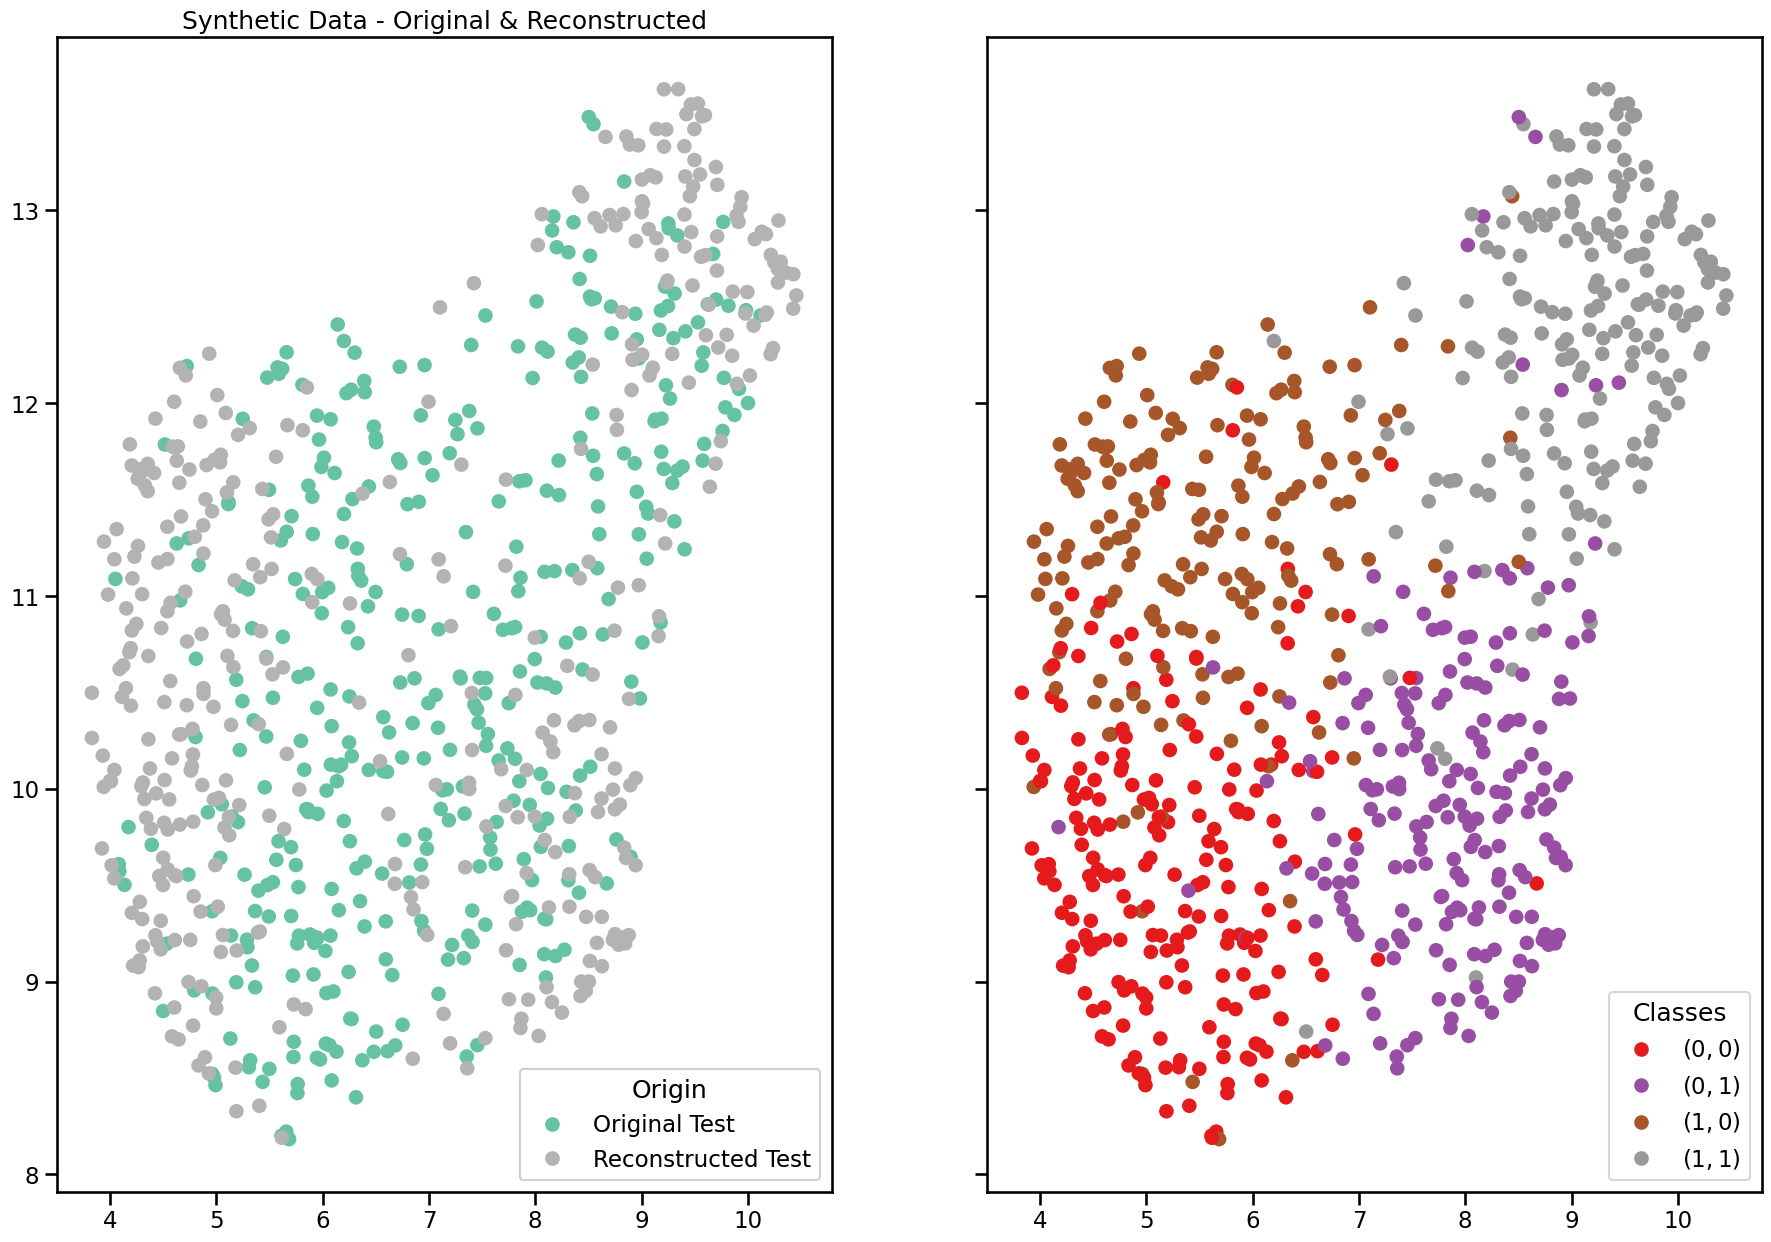

In [9]:
dat_t = predictive(test_set[:][0], test_set[:][1], test_set[:][1])["x"][0]

dat_tot = torch.concat((test_set[:][0], dat_t))
dat_tot_umap = reducer.fit_transform(dat_tot)

fig, ax = plt.subplots(1,2,figsize=(22,15), sharex=True, sharey=True)

scatter = ax[0].scatter(dat_tot_umap[:,0], dat_tot_umap[:,1], cmap="Set2", c= ([1]*len(test_set)) +([2]*len(test_set)))


elems = list(scatter.legend_elements())
elems[1] = [
 'Original Test',
  'Reconstructed Test']

legend = ax[0].legend(*elems, loc="lower right", title="Origin")
ax[0].add_artist(legend)

ax[0].set_title("Synthetic Data - Original & Reconstructed")


scatter = ax[1].scatter(dat_tot_umap[:,0], dat_tot_umap[:,1], cmap="Set1", c= get_labels(torch.concat((test_set[:][1], test_set[:][1]))).argmax(-1))


elems = list(scatter.legend_elements())
elems[1] = ['$\\mathdefault{(0,0)}$',
 '$\\mathdefault{(0,1)}$',
 '$\\mathdefault{(1,0)}$',
 '$\\mathdefault{(1,1)}$']

legend = ax[1].legend(*elems, loc="lower right", title="Classes")

plt.savefig("reconstruction_check.png", dpi=300, bbox_inches="tight")

plt.show()


### Understanding the Latent Components of the Model

As indicated in the paper, W denotes the attribute latent space (separated by classes) and Z denotes the common latent space (where separation w.r.t classes is kept to a minimum) 

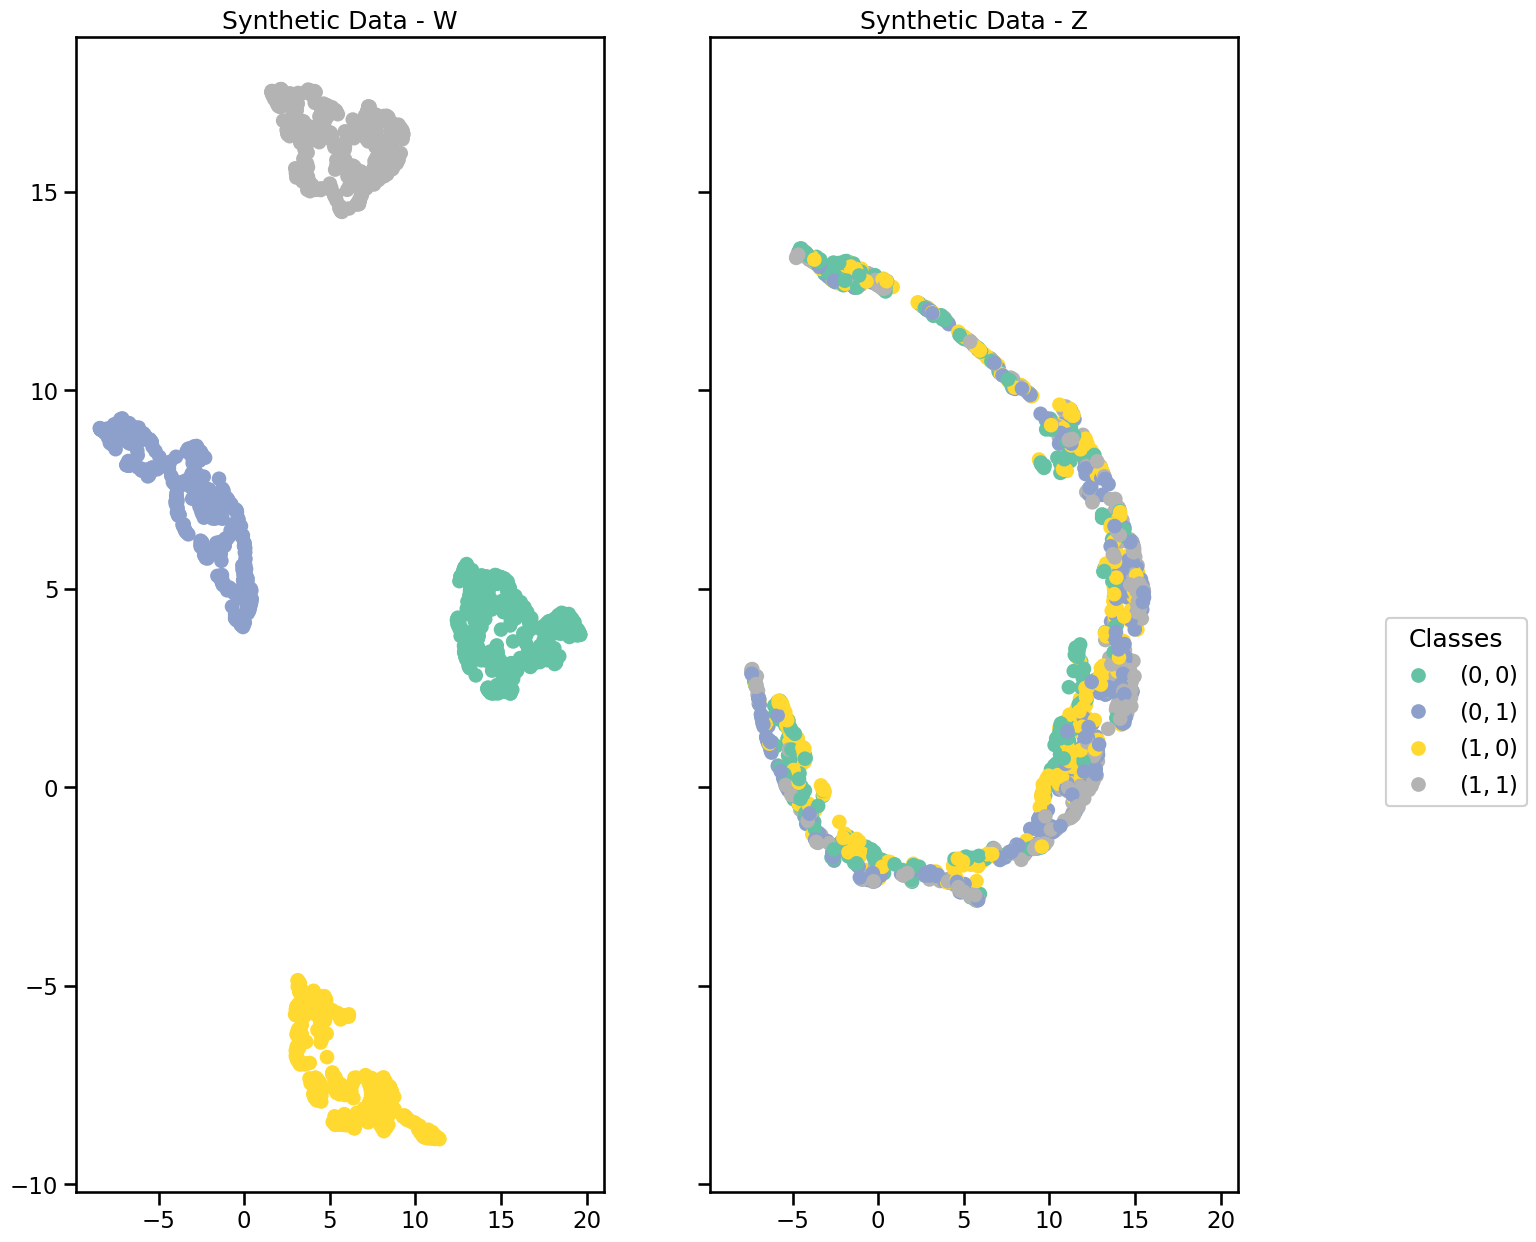

In [10]:
csscvi.eval()
csscvi = csscvi.cpu()
rho_latent = csscvi.rho_l_encoder(train_set[:][0])[0]
rho_y = _broadcast_inputs([rho_latent, train_set[:][1]])
rho_y = torch.cat(rho_y, dim=-1)


w_latent = csscvi.w_encoder(rho_y)[0]
z_latent = csscvi.z_encoder(rho_latent)[0]

data_w_mu = reducer.fit_transform(w_latent.detach().numpy())
data_z_mu = reducer.fit_transform(z_latent.detach().numpy())


fig, ax = plt.subplots(1,2,figsize=(15,15), sharex=True, sharey=True)

scatter = ax[0].scatter(data_w_mu[:,0], data_w_mu[:,1], c=np.array(get_labels(train_set[:][1]).argmax(-1)), cmap="Set2")
ax[1].scatter(data_z_mu[:,0], data_z_mu[:,1], c=np.array(get_labels(train_set[:][1]).argmax(-1)), cmap="Set2")


elems = list(scatter.legend_elements())
elems[1] = ['$\\mathdefault{(0,0)}$',
 '$\\mathdefault{(0,1)}$',
 '$\\mathdefault{(1,0)}$',
 '$\\mathdefault{(1,1)}$']

legend = fig.legend(*elems, bbox_to_anchor=(1.1,0.5), title="Classes")

ax[0].set_title("Synthetic Data - W")
ax[1].set_title("Synthetic Data - Z")

fig.add_artist(legend)


plt.savefig("synthetic_latents_learned.png", dpi=300, bbox_inches="tight")



plt.show()

### Mapping Between Conditions

Using the W latents, it is possible to map data points to other classes. This mapping is intuitively how the point would have looked had it belonged to another class in the first place (with keeping all of its information preserved in the Z space)

Steps for the mapping:

1. Encode source points into the Z (common) latent
2. Sample from the priors for the target label in the W (attribute) latent
3. Concatenate the Z & W vectors and decode

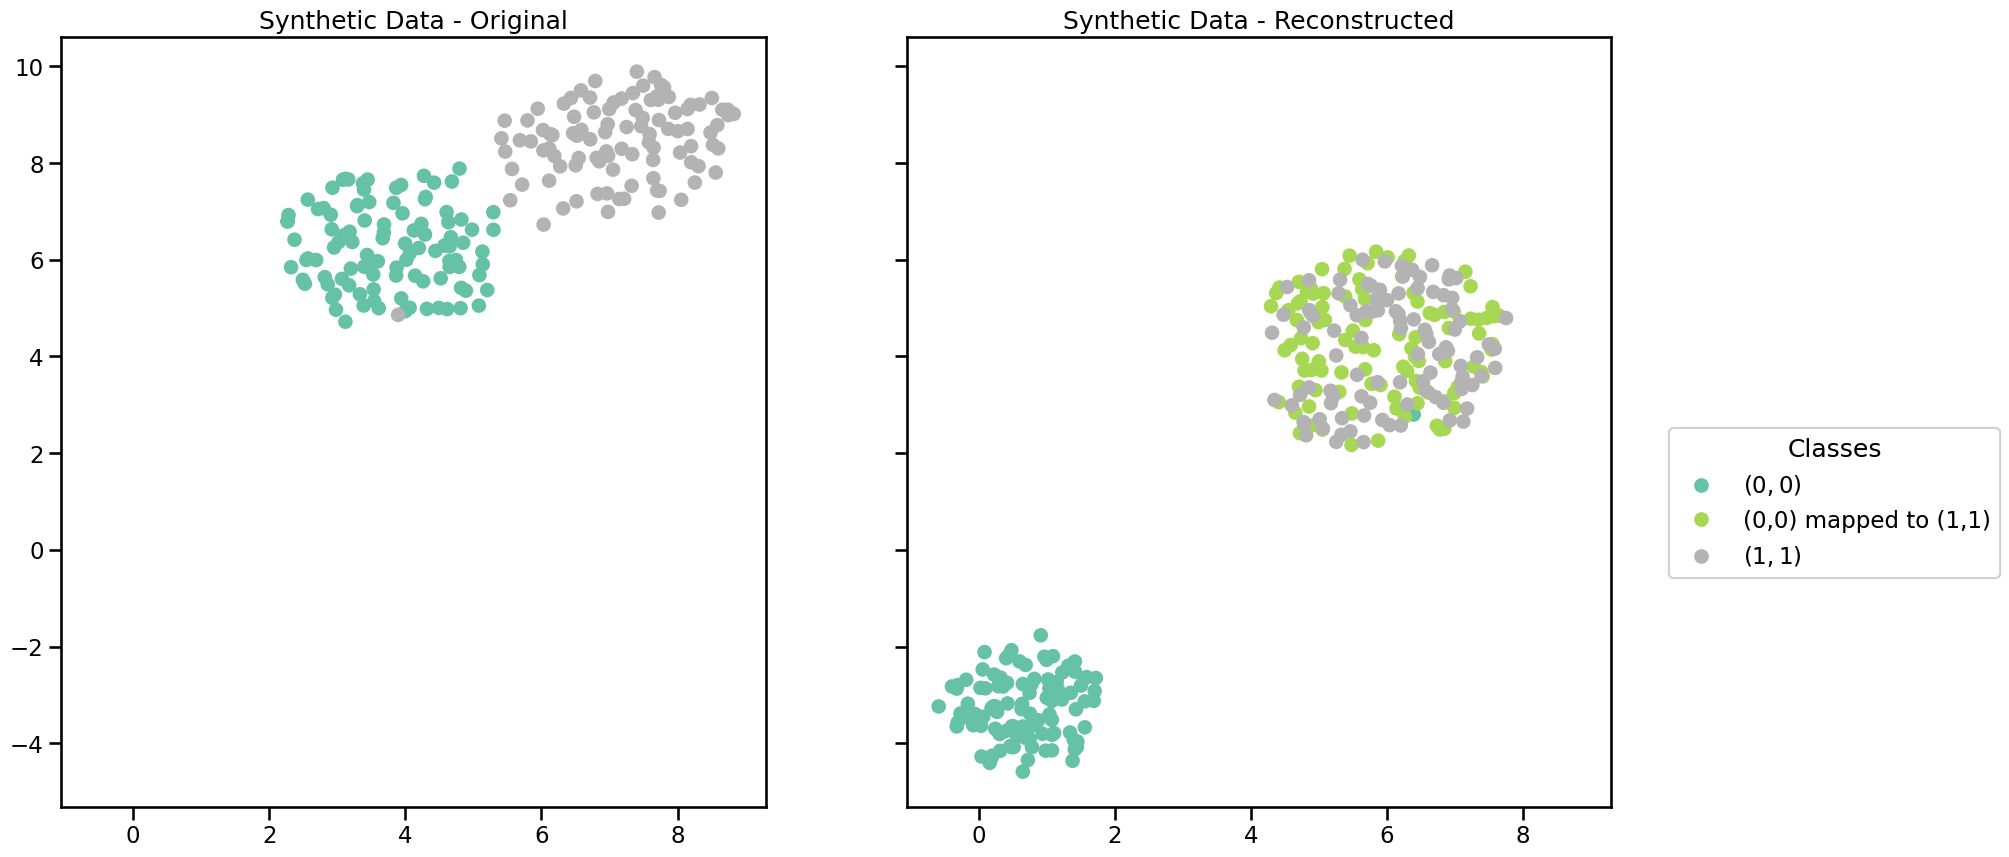

In [11]:
source_set, target_set = _get_subset(test_set, torch.tensor((1,0,1,0))), _get_subset(test_set, torch.tensor((0,1,0,1)))
transformed = csscvi.generate(source_set[:][0], y_source=source_set[:][1], y_target=torch.tensor((0,1,0,1)).double().repeat(len(source_set[:][1]),1))
reconstructed =  predictive(source_set[:][0], source_set[:][1], source_set[:][1])["x"][0]
reconstructed_target =  predictive(target_set[:][0], target_set[:][1], target_set[:][1])["x"][0]

dat_orig = torch.concat((source_set[:][0], target_set[:][0]))
dat_recon = torch.concat((reconstructed, transformed, reconstructed_target))

dat_orig_umap = reducer.fit_transform(dat_orig)
dat_recon_umap = reducer.fit_transform(dat_recon)

fig, ax = plt.subplots(1,2,figsize=(20,10), sharex=True, sharey=True)

ax[0].scatter(dat_orig_umap[:,0], dat_orig_umap[:,1], cmap="Set2", c= ([1]*len(source_set)) +([2]*len(target_set)))
scatter = ax[1].scatter(dat_recon_umap[:,0], dat_recon_umap[:,1], cmap="Set2", c= ([1]*len(source_set)) + ([2]*len(source_set)) + ([3]*len(target_set)))



elems = list(scatter.legend_elements())
elems[1] = [
 '$\\mathdefault{(0,0)}$',
 '(0,0) mapped to (1,1)',
    '$\\mathdefault{(1,1)}$']

legend = fig.legend(*elems, bbox_to_anchor=(1.1,0.5), title="Classes")

fig.add_artist(legend)


ax[0].set_title("Synthetic Data - Original")
ax[1].set_title("Synthetic Data - Reconstructed")



plt.savefig("mapping_with_synthetic_dat.png", dpi=300, bbox_inches="tight")



plt.show()